In [1]:
# Standard Imports
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.rcParams['font.size'] = 14
import seaborn as sns
%matplotlib inline

In [2]:
# Performance
from time import time

In [3]:
# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [28]:
# Helper
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.cross_validation import cross_val_predict, cross_val_score
from sklearn.cross_validation import KFold
from sklearn import metrics

# Preliminaries

In [5]:
# Load in the Data
train = pd.read_csv('input/train2.csv')
test = pd.read_csv('input/test2.csv')

In [6]:
train.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Gender,Port,AgeFill
0,1,0,3,1,0,7.2500,1,0,22
1,2,1,1,1,0,71.2833,0,1,38
2,3,1,3,0,0,7.9250,0,0,26
3,4,1,1,1,0,53.1000,0,0,35
4,5,0,3,0,0,8.0500,1,0,35


In [7]:
# create hold-out set
features = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Gender', 'Port', 'AgeFill']
X_train, X_test, y_train, y_test = train_test_split(train[features], train['Survived'])

In [8]:
len(y_train)/6

111.0

In [9]:
# use train/test split to examine results via confusion matrix and AUC 

In [10]:
# null accuracy
null_accuracy = train.Survived.value_counts().max()/len(train.Survived)
print(null_accuracy)

0.617547806524


# Feature selection

CV score is  0.777777777778


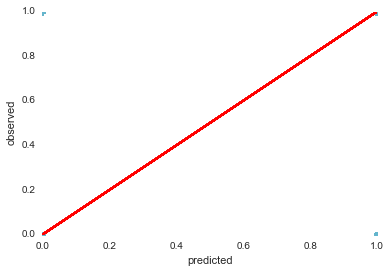

In [29]:
# split the training data into train and test sets

clf = RandomForestClassifier(n_estimators = 100)
scores = []

kf = KFold(len(y_train), n_folds=6)

for train, test in kf:

    xtrain, xtest, ytrain, ytest = X_train.iloc()[train], X_train.iloc()[test], y_train.iloc()[train], y_train.iloc()[test]
    
    b = SelectKBest(chi2, k = 4)
    b.fit(xtrain, ytrain)
    xtrain = xtrain.iloc()[:, b.get_support()]
    xtest = xtest.iloc()[:, b.get_support()]
    
    clf.fit(xtrain, ytrain)
    scores.append(clf.score(xtest,ytest))
    
    yp = clf.predict(xtest)
    plt.plot(yp, ytest, 'o')
    plt.plot(ytest, ytest, 'r-')
    
plt.xlabel("predicted")
plt.ylabel("observed")

print("CV score is ", np.mean(scores))
    

In [25]:
yp

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int64)

# Parameter tuning
**Goal**: select best number of estimators for random forest

In [35]:
features = ['Pclass', 'Fare', 'Gender', 'AgeFill', 'Port']
tree_range = [1, 25, 50, 100, 125, 150, 175, 200, 250]
tree_scores = []
for tree_num in tree_range:
    clf = RandomForestClassifier(n_estimators = tree_num)
    scores = cross_val_score(clf, train[features], train['Survived'], cv = 10, scoring = 'accuracy')
    tree_scores.append(scores.mean())

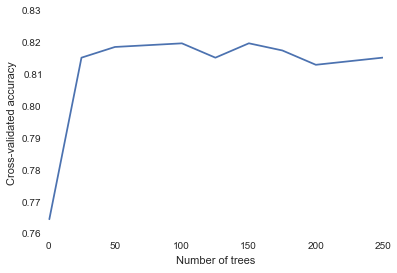

In [36]:
# plot scores for tree #'s
plt.plot(tree_range, tree_scores)
plt.xlabel("Number of trees")
plt.ylabel("Cross-validated accuracy")

# Model selection
**Goal**: compare the best random forest model with logistic regression

In [38]:
clf1 = RandomForestClassifier(n_estimators = 100)
print(cross_val_score(clf1, train[features], train['Survived'], cv = 10, scoring = 'accuracy').mean())


0.812180796731


In [40]:
clf2 = LogisticRegression()
print(cross_val_score(clf2, train[features], train['Survived'], cv = 10, scoring = 'accuracy').mean())


0.795250255363


# Training the model

In [8]:
# Create the random forest object which will include all the parameters
# for the fit
forest = RandomForestClassifier(n_estimators = 100)

# Fit the training data to the Survived labels and create the decision trees
# forest.fit(training[0::,2::],training[0::,1])
# forest.fit(train[['Pclass', 'Fare', 'Gender', 'AgeFill']], train['Survived'])



In [24]:
# for classification, stratified sampling should be included in cross-validation (so each class is represented proportionally
# in each fold). Cross_val_score does this by default
forest_train_pred = cross_val_predict(forest, train[['Pclass', 'Fare', 'Gender', 'AgeFill']], train['Survived'], cv=10)
score = cross_val_score(forest, train[['Pclass', 'Fare', 'Gender', 'AgeFill']], train['Survived'], cv=10, scoring = 'accuracy')
print("Random forest accuracy: ", metrics.accuracy_score(train.Survived, forest_train_pred))
print("Out of sample accuracy", score.mean())

Random forest accuracy:  0.813273340832
Out of sample accuracy 0.822305924413


In [ ]:
# Take the same decision trees and run it on the test data
output = forest.predict(test)

# Model evaluation

In [10]:
# basic comparison
print('Pred:', forest_train_pred[0:10])
print('True:', train.Survived[0:10])

Pred: [0 1 0 1 0 0 1 1 1 1]
True: 0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    1
9    1
Name: Survived, dtype: int64


In [11]:
labels = ["Died", "Lived"]
confusion = metrics.confusion_matrix(train.Survived, forest_train_pred)
print(confusion)
# columns are predicted (0, 1)
# rows are actual values (0, 1)

[[471  78]
 [115 225]]


In [ ]:
# what metric want to optimize? reduce false positives (spam filter; specificity/precision)
# or false negatives (fraud detection; sensitivity)?

# in this case, sensitivity is low - detecting less than 70% of titanic survivors

In [12]:
# Sensitivity/true positive (when actual value is positive, 
# how often is prediction correct?)

# 225/(225+115)
print(metrics.recall_score(train.Survived, forest_train_pred))

0.661764705882


In [13]:
# Specificity (when actual value is negative,
# how often is prediction correct?)

print(471/(471+78))

0.8579234972677595


In [14]:
# False positive rate: when actual value is negative, 
# how often is the prediction incorrect?

print(78/(471+78))

0.14207650273224043


In [15]:
# Precision of the classifier: when positive value is PREDICTED,
# how often is the prediction correct?
print(225/(78+225))
print(metrics.precision_score(train.Survived, forest_train_pred))

0.7425742574257426
0.742574257426


# Adjusting classification threshold

In [16]:
features = ['Pclass', 'Fare', 'Gender', 'AgeFill']
forest.predict(train[features])[0:10]

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [49]:
forest.predict_proba(train[features])[0:10, :]

array([[ 1.  ,  0.  ],
       [ 0.02,  0.98],
       [ 0.17,  0.83],
       [ 0.  ,  1.  ],
       [ 1.  ,  0.  ],
       [ 0.99,  0.01],
       [ 0.87,  0.13],
       [ 0.65,  0.35],
       [ 0.13,  0.87],
       [ 0.  ,  1.  ]])

In [50]:
y_pred_prob = forest.predict_proba(train[features])[:, 1]

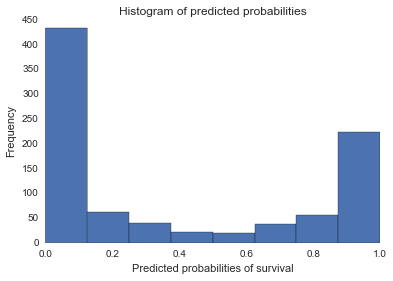

In [40]:
# histogram of predicted probabilities
plt.hist(y_pred_prob, bins = 8)
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probabilities of survival')
plt.ylabel('Frequency')

In [45]:
# decrease the threshold for predicting survival in order
# to increase the sensitivity of the classifier
from sklearn.preprocessing import binarize
y_pred_class = binarize(y_pred_prob, 0.30)[0]

In [46]:
y_pred_prob[0:10]

array([ 0.  ,  0.98,  0.83,  1.  ,  0.  ,  0.01,  0.13,  0.35,  0.87,  1.  ])

In [47]:
y_pred_class[0:10]

array([ 0.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  1.])

In [52]:
# previous confusion matrix
print(confusion)

[[461  88]
 [112 228]]


In [ ]:
# new confusion matrix
print(metrics.confusion_matrix(test.))